<a href="https://colab.research.google.com/github/marcinwolter/SummerStudent2022_autoencoder/blob/main/Modified_vae_to_simple_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

https://keras.io/examples/generative/vae/

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create a sampling layer

In [2]:
'''
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
'''

'\nclass Sampling(layers.Layer):\n    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""\n\n    def call(self, inputs):\n        z_mean, z_log_var = inputs\n        batch = tf.shape(z_mean)[0]\n        dim = tf.shape(z_mean)[1]\n        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))\n        return z_mean + tf.exp(0.5 * z_log_var) * epsilon\n'

## Build the encoder

In [3]:
'''
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
'''

'\nlatent_dim = 2\n\nencoder_inputs = keras.Input(shape=(28, 28, 1))\nx = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)\nx = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)\nx = layers.Flatten()(x)\nx = layers.Dense(16, activation="relu")(x)\nz_mean = layers.Dense(latent_dim, name="z_mean")(x)\nz_log_var = layers.Dense(latent_dim, name="z_log_var")(x)\nz = Sampling()([z_mean, z_log_var])\nencoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")\nencoder.summary()\n'

In [4]:
'''
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, x, name="encoder")
encoder.summary()
'''

'\nlatent_dim = 2\n\nencoder_inputs = keras.Input(shape=(28, 28, 1))\nx = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)\nx = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)\nx = layers.Flatten()(x)\nx = layers.Dense(16, activation="relu")(x)\nz_mean = layers.Dense(latent_dim, name="z_mean")(x)\nz_log_var = layers.Dense(latent_dim, name="z_log_var")(x)\nz = Sampling()([z_mean, z_log_var])\nencoder = keras.Model(encoder_inputs, x, name="encoder")\nencoder.summary()\n'

## Build the decoder

In [5]:
'''
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()
'''

'\nlatent_inputs = keras.Input(shape=(latent_dim,))\nx = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)\nx = layers.Reshape((7, 7, 64))(x)\nx = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)\nx = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)\ndecoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)\ndecoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")\ndecoder.summary()\n'

In [6]:

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = layers.Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = layers.Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = layers.Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = layers.Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = layers.Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return keras.Model(inputs=input_img, outputs=decoded, name='AE'), keras.Model(inputs=input_img, outputs=encoded, name='encoder')


## Define the VAE as a `Model` with a custom `train_step`

In [7]:
'''
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
'''

'\nclass VAE(keras.Model):\n    def __init__(self, encoder, decoder, **kwargs):\n        super(VAE, self).__init__(**kwargs)\n        self.encoder = encoder\n        self.decoder = decoder\n        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")\n        self.reconstruction_loss_tracker = keras.metrics.Mean(\n            name="reconstruction_loss"\n        )\n        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")\n\n    @property\n    def metrics(self):\n        return [\n            self.total_loss_tracker,\n            self.reconstruction_loss_tracker,\n            self.kl_loss_tracker,\n        ]\n\n    def train_step(self, data):\n        with tf.GradientTape() as tape:\n            z_mean, z_log_var, z = self.encoder(data)\n            reconstruction = self.decoder(z)\n            reconstruction_loss = tf.reduce_mean(\n                tf.reduce_sum(\n                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)\n                

## Train the VAE

In [8]:
'''
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)
'''

'\n(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()\nmnist_digits = np.concatenate([x_train, x_test], axis=0)\nmnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255\n\nvae = VAE(encoder, decoder)\nvae.compile(optimizer=keras.optimizers.Adam())\nvae.fit(mnist_digits, epochs=30, batch_size=128)\n'

In [9]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

print(mnist_digits.shape)
mnist_digits = mnist_digits.reshape(len(mnist_digits),784)

from keras.initializers import VarianceScaling

dims = [mnist_digits.shape[-1], 500, 500, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')

autoencoder, encoder = autoencoder(dims, init=init)

autoencoder.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')
autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

(70000, 28, 28, 1)
Epoch 1/30
547/547 [==============================] - 5s 6ms/step - loss: 0.2923
Epoch 2/30
547/547 [==============================] - 3s 6ms/step - loss: 0.2328
Epoch 3/30
547/547 [==============================] - 3s 6ms/step - loss: 0.2073
Epoch 4/30
547/547 [==============================] - 3s 6ms/step - loss: 0.2058
Epoch 5/30
547/547 [==============================] - 2s 5ms/step - loss: 0.2230
Epoch 6/30
547/547 [==============================] - 2s 4ms/step - loss: 0.2093
Epoch 7/30
547/547 [==============================] - 2s 4ms/step - loss: 0.1945
Epoch 8/30
547/547 [==============================] - 2s 4ms/step - loss: 0.1884
Epoch 9/30
547/547 [==============================] - 2s 4ms/step - loss: 0.1965
Epoch 10/30
547/547 [==============================] - 2s 4ms/step - loss: 0.2169
Epoch 11/30
547/547 [==============================] - 2s 4ms/step - loss: 0.2087
Epoch 12/30
547/547 [==============================] - 2s 4ms/step - loss: 0.2122
Epoch 

## Display a grid of sampled digits

In [10]:
'''
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(decoder)
'''

'\nimport matplotlib.pyplot as plt\n\n\ndef plot_latent_space(vae, n=30, figsize=15):\n    # display a n*n 2D manifold of digits\n    digit_size = 28\n    scale = 1.0\n    figure = np.zeros((digit_size * n, digit_size * n))\n    # linearly spaced coordinates corresponding to the 2D plot\n    # of digit classes in the latent space\n    grid_x = np.linspace(-scale, scale, n)\n    grid_y = np.linspace(-scale, scale, n)[::-1]\n\n    for i, yi in enumerate(grid_y):\n        for j, xi in enumerate(grid_x):\n            z_sample = np.array([[xi, yi]])\n            x_decoded = vae.predict(z_sample)\n            digit = x_decoded[0].reshape(digit_size, digit_size)\n            figure[\n                i * digit_size : (i + 1) * digit_size,\n                j * digit_size : (j + 1) * digit_size,\n            ] = digit\n\n    plt.figure(figsize=(figsize, figsize))\n    start_range = digit_size // 2\n    end_range = n * digit_size + start_range\n    pixel_range = np.arange(start_range, end_range, 

## Display how the latent space clusters different digit classes

In [11]:
'''
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)
'''

'\ndef plot_label_clusters(vae, data, labels):\n    # display a 2D plot of the digit classes in the latent space\n    z_mean, _, _ = vae.encoder.predict(data)\n    plt.figure(figsize=(12, 10))\n    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)\n    plt.colorbar()\n    plt.xlabel("z[0]")\n    plt.ylabel("z[1]")\n    plt.show()\n\n\n(x_train, y_train), _ = keras.datasets.mnist.load_data()\nx_train = np.expand_dims(x_train, -1).astype("float32") / 255\n\nplot_label_clusters(vae, x_train, y_train)\n'

(60000, 10)


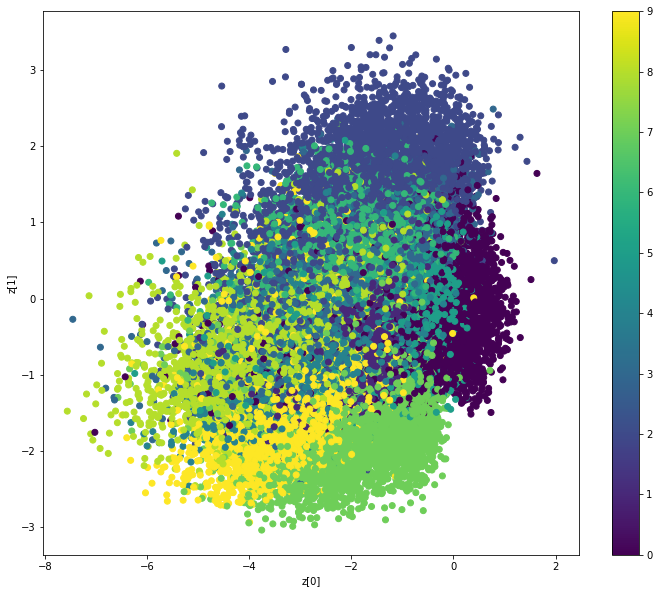

In [12]:
import matplotlib.pyplot as plt

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean = vae.predict(data.reshape(len(data),784))
    print(z_mean.shape)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

#**Clustering using k-means algorithm from scikit-learn**

(60000, 10)


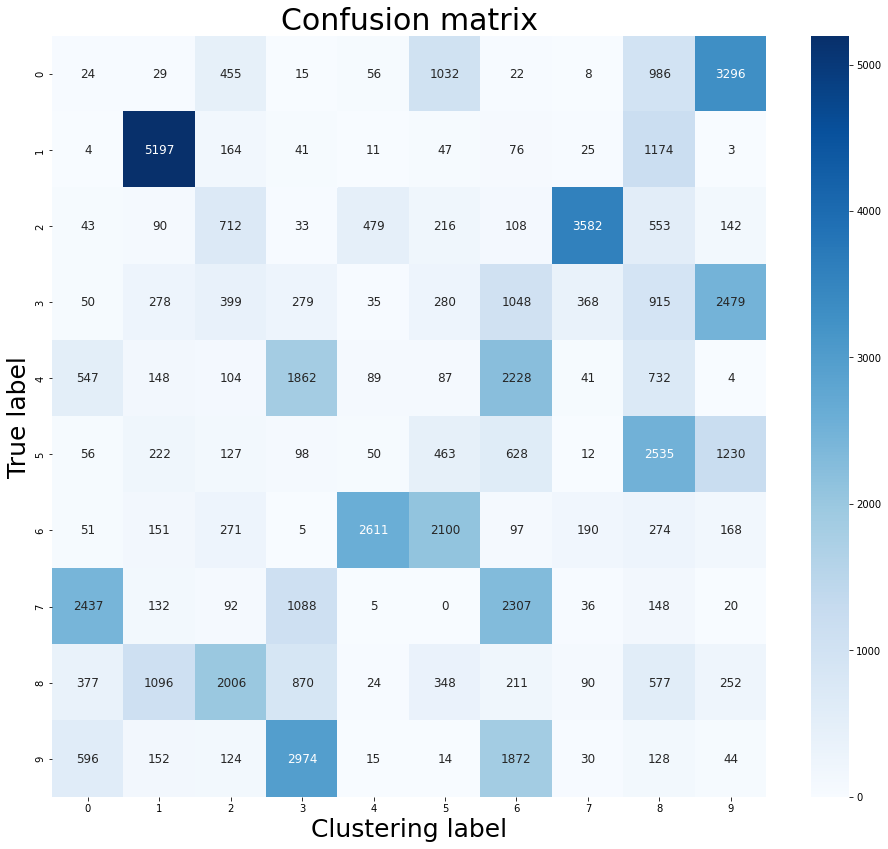

In [13]:
from sklearn.cluster import KMeans
from sklearn import metrics

n_clusters = 10
z_mean = encoder.predict(x_train.reshape(len(x_train),784))
print(z_mean.shape)
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
y_pred_kmeans = kmeans.fit_predict(z_mean)


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred_kmeans)

plt.figure(figsize=(16, 14))
import seaborn as sns
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 12})
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [16]:

print(metrics.rand_score(y_train, y_pred_kmeans))


0.859828446029656
